In [20]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [21]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [22]:
image_size = 224

augment_flag = False
#augment_flag = True

# exp_model = "model_1"  # base
#exp_model = "model_2" #resnet v2 나름 괜찮음. conv_5 block_3부터 재학습하면 max val_acc 0.79
#exp_model = "model_3" #efficientnet b4 # 전혀 학습이 안됨. val_accuracy 0.17 근처(~ 1/ 6)
#exp_model = "model_4" #MoblileNet v2 # 
exp_model = "model_5" # DenseNet121

#base_model_trainable = False
base_model_trainable = True

if exp_model == "model_1":
    pass
elif exp_model == "model_2":
    train_layer_from = 177     # conv_5 block_3부터 재학습
elif exp_model == "model_3":
    train_layer_from = 177
elif exp_model == "model_4":
    train_layer_from = 144      # 
    train_layer_from = 151      # 
    
elif exp_model == "model_5":
    train_layer_from = 313
    
n_train_epoch = 50

rgb_standardization = False
#rgb_standardization = True

## 데이터 불러 오기

### 데이터 로드 함수 정의



In [23]:
import os
from PIL import Image

# 하나의 디렉토리(dir_path)의 이미지화일(.jpg, .jpeg)을 읽어서 list를 리턴하는 함수
# 이 때 이미지를 (target_size, target_size)로 리사이즈 한다.
def load_images_from_dir(dir_path, target_size = 224):
    images = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            #if file.lower().endswith(('.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    new_img = img.resize((target_size, target_size),Image.ANTIALIAS)
                    images.append(new_img)
                except IOError:
                    print(f"Cannot load image: {file_path}")
    return images

### 이미지 화일을 읽어서 폴더별로 라벨링 한다.
- 라벨은 헤당 클래스가 class_dir_list에 나타나는 순서

In [24]:
# import numpy as np
import os

class_dir_list = ["barrel_jellyfish",          # 0
                    "blue_jellyfish",          # 1
                   "compass_jellyfish",        # 2
                   "lions_mane_jellyfish",     # 3
                    "mauve_stinger_jellyfish", # 4
                    "Moon_jellyfish"]          # 5

# 하위 디렉토리(class_dir_list에 있는)를 순회하면서 이미지 화일을 읽고
# 디렉토리에 따라 라벨링을 해준다.
# 라벨은 class_dir_list에 나타나는 해파리명의 순서
def load_data_with_label(img_root_list, img_sub_dir, max_number_of_data=10000, class_dir_list = ""):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=224
    color=3

    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    images=np.zeros(max_number_of_data*img_size*img_size*color,dtype=np.int32).reshape(max_number_of_data,img_size,img_size,color)
    labels=np.zeros(max_number_of_data,dtype=np.int32)

    idx=0
    
    for img_root_dir in img_root_list:
        img_path = img_root_dir + img_sub_dir
        print(img_path)
        for label, dir_name in enumerate(class_dir_list):
            class_image_dir = img_path + "/" + dir_name
            class_images = load_images_from_dir(class_image_dir)
            for i in range(len(class_images)):
                images[idx, :, :, :] = class_images[i]
                labels[idx] = label
                idx += 1
    
    print("데이터의 이미지 개수는", idx,"입니다.")
    images = images[:idx]
    labels = labels[:idx]

    return images, labels


### train, validataion, test data와 label을 로드한다.

In [25]:
#img_root_list = ["/aiffel/aiffel/jellyfish/Train_Test_Valid/"]
img_root_list = ["/aiffel/aiffel/jellyfish2/Train_Test_Valid/"]
#img_root_list = ["/aiffel/aiffel/jellyfish/Label_Reviewed/Train_Test_Valid/"]

# img_root_list = ["/aiffel/aiffel/jellyfish/Train_Test_Valid/",
#              "/aiffel/aiffel/jellyfish/Add_Data/"]

# img_root_list = ["/aiffel/aiffel/jellyfish/Label_Reviewed/Train_Test_Valid/",
#              "/aiffel/aiffel/jellyfish/Add_Data/"]

#img_root_list = ["/aiffel/aiffel/jellyfish/Add_Data/"]

train_data, train_labels = load_data_with_label(img_root_list, "Train",
                           class_dir_list = class_dir_list)

val_data, val_labels = load_data_with_label(img_root_list, "valid",
                           class_dir_list = class_dir_list)

test_data, test_labels = load_data_with_label(img_root_list, "test",
                           class_dir_list = class_dir_list)


/aiffel/aiffel/jellyfish2/Train_Test_Valid/Train
데이터의 이미지 개수는 900 입니다.
/aiffel/aiffel/jellyfish2/Train_Test_Valid/valid
데이터의 이미지 개수는 39 입니다.
/aiffel/aiffel/jellyfish2/Train_Test_Valid/test
데이터의 이미지 개수는 40 입니다.


In [26]:
import tensorflow as tf

def rotate_image(image):
    return tf.image.rot90(image)

def zoom_image(image, size=(224, 224)):
    # 이미지 중앙을 기준으로 확대 후 원본 크기로 조정
    zoomed = tf.image.central_crop(image, 0.8)
    return tf.image.resize(zoomed, size)

def adjust_contrast_image(image):
    adjusted_image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    clipped_image = tf.clip_by_value(adjusted_image, 0, 255)

    return clipped_image

def adjust_brightness_image(image):
    adjusted_image = tf.image.random_brightness(image, max_delta=0.2)
    clipped_image = tf.clip_by_value(adjusted_image, 0, 255)
    
    return clipped_image

def flip_left_right_image(image):
    return tf.image.flip_left_right(image)

def augment_dataset_with_labels(data, labels):
    augmented_data = []
    augmented_labels = []

    for image, label in zip(data, labels):
        augmented_images = [
            image,
            rotate_image(image).numpy(),
            #flip_left_right_image(image).numpy(),
            #zoom_image(image).numpy()
            adjust_contrast_image(image).numpy()
            #adjust_brightness_image(image).numpy()
        ]

        for aug_image in augmented_images:
            augmented_data.append(aug_image)
            augmented_labels.append(label)

    return np.array(augmented_data), np.array(augmented_labels)

# 데이터셋 적용 예시
# train_data, train_label = ...

if augment_flag:
    train_data, train_labels = augment_dataset_with_labels(train_data, train_labels)

In [27]:
train_data.shape

(900, 224, 224, 3)

### 로드한 이미지 그려 보기

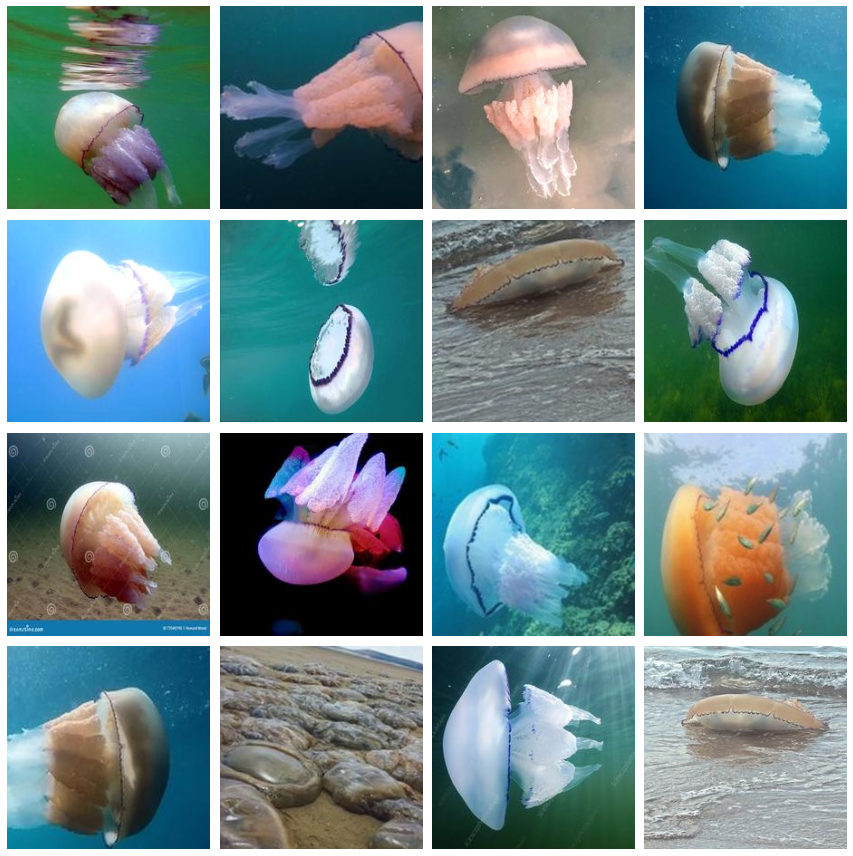

In [28]:
import matplotlib.pyplot as plt

def show_images_in_matrix(images, rows=4, cols=4):
    """
    Displays images in a grid format using matplotlib.

    :param images: A list of PIL Image objects.
    :param rows: The number of rows in the image grid.
    :param cols: The number of columns in the image grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(images):
            axes[i].imshow(images[i])
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
show_images_in_matrix(train_data[:16])
#show_images_in_matrix(train_data[-16:])
    
# Example usage:
# images = [Your list of PIL Image objects]
# show_images_in_matrix(images)

# Replace [Your list of PIL Image objects] with a list of PIL Image objects.


### 데이터 shape 확인

In [29]:
print(train_data.shape)
print(train_labels.shape)

print(val_data.shape)
print(val_labels.shape)

print(test_data.shape)
print(test_labels.shape)


(900, 224, 224, 3)
(900,)
(39, 224, 224, 3)
(39,)
(40, 224, 224, 3)
(40,)


### 데이터 scale 조정

In [30]:
def standardize_dataset(data):
    # 데이터셋 전체에 대한 평균과 표준편차를 계산
    mean = np.mean(data, axis=(0, 1, 2))
    std = np.std(data, axis=(0, 1, 2))

    # 데이터셋을 표준화
    standardized_data = (data - mean) / std
    return standardized_data

if rgb_standardization:
    # 가정: data는 (data_num, 224, 224, 3) 형태의 NumPy 배열
    train_data_std = standardize_dataset(train_data)
    val_data_std = standardize_dataset(val_data)
    test_data_std = standardize_dataset(test_data)
else:
    train_data_std = train_data / 255.0   # 입력은 0~1 사이의 값으로 정규화
    val_data_std = val_data / 255.0   # 입력은 0~1 사이의 값으로 정규화
    test_data_std = test_data / 255.0   # 입력은 0~1 사이의 값으로 정규화

print("train_data shape: {}".format(train_data_std.shape))
print("train_label shape: {}".format(train_labels.shape))

train_data shape: (900, 224, 224, 3)
train_label shape: (900,)


### train data 섞기

In [ ]:
import numpy as np

# 인덱스 배열 생성
indices = np.arange(len(train_data))

# 인덱스 배열을 무작위로 섞기
np.random.shuffle(indices)

# 인덱스를 사용하여 데이터와 라벨을 섞기
train_data = train_data[indices]
train_data_std = train_data_std[indices]
train_labels = train_labels[indices]


### 스케일 조정된 데이터 확인

In [ ]:
train_data_std[0]

### 모델 정의
- LeNet의 정의을 그대로 따랐다.
- 가장 큰 차이는 convolution layer를 하나 더 넣었다는 것이다.

In [ ]:
# pretrained model retrain 정도 결정 함수

# base_model : pretrained model
# model_trainable : 모델이 retrainable 한가? False면 retrain_layer_from에 상관없이 retrain 안함
# train_layer_from : 어떤 layer부터 retrain할 것인가?
#    retrain 가능한 layer를 보여준다.
def set_base_model_retrainable(base_model, 
                               model_trainable = False, 
                               train_layer_from = 0):
    base_model.trainable = model_trainable
    if (model_trainable):
        if (train_layer_from < len(base_model.layers)):
            for layer in base_model.layers[:train_layer_from]:
                layer.trainable = False

        print("[Retrainable layers]")        
        for i, layer in enumerate(base_model.layers):
            if layer.trainable:
                print(i, layer.name)

# base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape = (image_size, image_size, 3),
#                          include_top=False,
#                          weights='imagenet')

# set_base_model_retrainable(base_model, True, train_layer_from = 100)



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import AveragePooling2D, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras import backend as K

import numpy as np
print(exp_model)

if exp_model == "model_1":
    # 모델 1
    # model을 직접 만들어 보세요.
    # Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
    n_channel_1=32
    n_channel_2=64
    n_channel_3=128
    n_channel_4=256
    n_dense_1= 128
    n_dense_2 = 64
    #n_train_epoch=50

    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), \
                                  activation='relu', \
                                  input_shape=(image_size,image_size,3)))
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Conv2D(n_channel_4, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))

    model.add(keras.layers.Flatten())
    #model.add(keras.layers.Dense(n_dense_1, activation='relu'))
    #model.add(keras.layers.BatchNormalization())  # Batch Normalization
    model.add(keras.layers.Dense(n_dense_2, activation='relu'))
    #model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(6, activation='softmax'))
elif exp_model == "model_2":
    # 모델 2
    # Create the base model from the pre-trained model VGG16
    base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape = (image_size, image_size, 3),
                                             include_top=False,
                                             weights='imagenet')
    input = tf.keras.layers.Input(shape = (image_size, image_size, 3))
    feature_batch = base_model(input)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    #inputs = tf.keras.Input(shape = (image_size, image_size, 3))
    feature_batch_average = global_average_layer(feature_batch)

    dense_layer = tf.keras.Sequential([
      tf.keras.layers.Dense(units = 32),
      #tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu")]
    )

    batch_layer = tf.keras.layers.BatchNormalization()

    dense_layer_2 = tf.keras.Sequential([
      tf.keras.layers.Dense(units = 32),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation("relu")]
    )

    prediction_layer = Dense(units = 6, activation = "softmax")

    # feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
    prediction_batch = prediction_layer(dense_layer(feature_batch_average))  

    set_base_model_retrainable(base_model, base_model_trainable, train_layer_from)

    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      dense_layer,
      #batch_layer,
      #dense_layer_2,
      prediction_layer
    ])
elif exp_model == "model_3": # 전혀 학습이 안됨. val_accuracy 0.17 근처(~ 1/ 6)
    # 사전 훈련된 EfficientNet B4 모델 불러오기
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', 
                                                     include_top=False, input_shape=(image_size, image_size, 3))

    set_base_model_retrainable(base_model, base_model_trainable, train_layer_from)

    input = tf.keras.layers.Input(shape = (image_size, image_size, 3))

    # 새로운 분류 레이어 추가
    x = base_model(input)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(6, activation='softmax')(x)  # num_classes는 데이터셋의 클래스 수

    # 최종 모델 정의
    model = Model(inputs=input, outputs=predictions)
elif exp_model == "model_4":
    print(exp_model)
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', 
                                                    include_top=False, input_shape=(image_size, image_size, 3))
    #print(base_model_trainable)
    set_base_model_retrainable(base_model, base_model_trainable, train_layer_from)

    input = tf.keras.layers.Input(shape = (image_size, image_size, 3))

    # 새로운 분류 레이어 추가
    x = base_model(input)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(6, activation='softmax')(x)  # num_classes는 데이터셋의 클래스 수

    # 최종 모델 정의
    model = Model(inputs=input, outputs=predictions)
elif exp_model == "model_5":
    base_model = tf.keras.applications.DenseNet121(weights='imagenet', 
                                                    include_top=False, input_shape=(image_size, image_size, 3))
    set_base_model_retrainable(base_model, base_model_trainable, train_layer_from)

    input = tf.keras.layers.Input(shape = (image_size, image_size, 3))

    # 새로운 분류 레이어 추가
    x = base_model(input)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(6, activation='softmax')(x)  # num_classes는 데이터셋의 클래스 수

    # 최종 모델 정의
    model = Model(inputs=input, outputs=predictions)
    
#tf.keras.applications.MobileNetV2    
model.summary()

### 학습 실행

In [ ]:


model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
#model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = 0.0002),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


# 훈련 및 평가
history = model.fit(train_data_std, train_labels, 
                    epochs=n_train_epoch, 
                    batch_size = 32, 
                    validation_data=(val_data_std, val_labels))



### 학습 결과(accuracy, loss) 그래프

In [ ]:
# 4. 결과를 그래프로 표시
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# val_accuracy가 최대인 에폭과 그 값을 찾기
max_val_accuracy_epoch = np.argmax(history.history['val_accuracy'])
max_val_accuracy = history.history['val_accuracy'][max_val_accuracy_epoch]


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title(f'Accuracy over epochs({max_val_accuracy:.4f}@{max_val_accuracy_epoch})')

# val_loss가 최소인 에폭과 그 값을 찾기
min_val_loss_epoch = np.argmin(history.history['val_loss'])
min_val_loss = history.history['val_loss'][min_val_loss_epoch]

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Loss over epochs({min_val_loss:.4f}@{min_val_loss_epoch})')

plt.tight_layout()
plt.show()

### 테스트 정확도 

In [ ]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(test_data_std, test_labels, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

### 테스트 추론 결과와 라벨 비교

In [ ]:
predicted_result = model.predict(test_data_std)  # model이 추론한 확률값. 
#print(predicted_result)
predicted_labels = np.argmax(predicted_result, axis=1)

for idx in np.random.choice(len(predicted_labels), 10):
    #idx=150 #1번째 x_test를 살펴보자. 
    print('model.predict() 결과 : ', predicted_result[idx])
    print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx], class_dir_list[predicted_labels[idx]])
    print('실제 데이터의 라벨 : ', test_labels[idx], class_dir_list[test_labels[idx]])

    plt.imshow(test_data[idx])
    plt.show()

## ResNet V2
### no_aug
model-2, no aug, dense 32
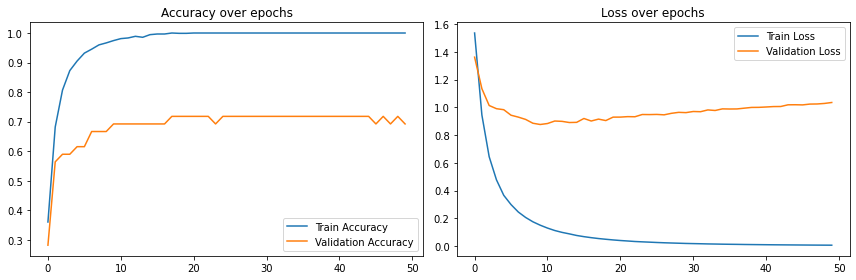

model-2, no aug, dense 32, batchnormal
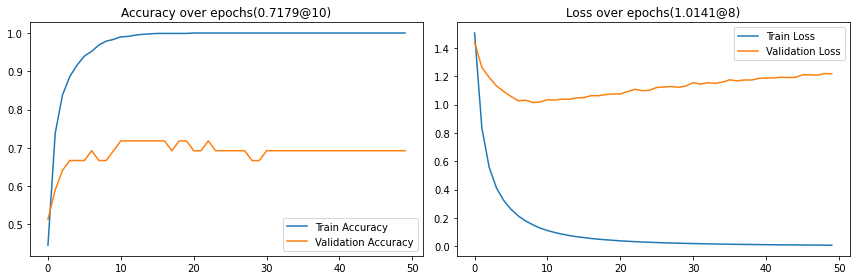

model-2, no aug, dense 32, batchnormal, resnet retrain from 158(conv5 block1)
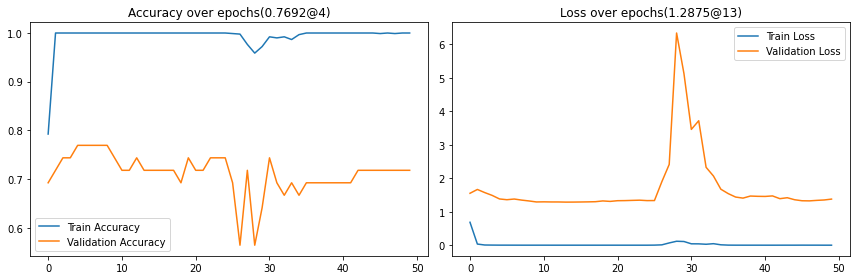

model-2, no aug, dense 32, batchnormal, resnet retrain from 76(conv3 block4)
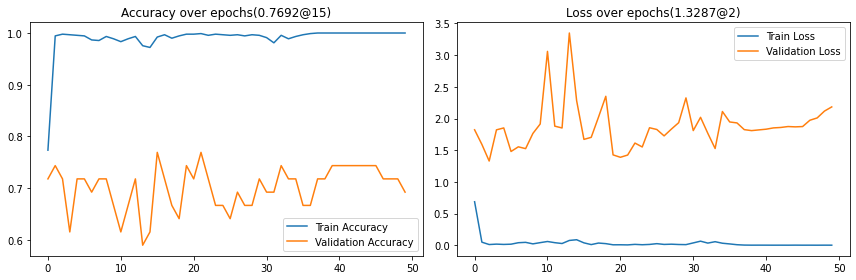

model-2, no aug, dense 32, batchnormal, resnet retrain from 177(conv5 block3)
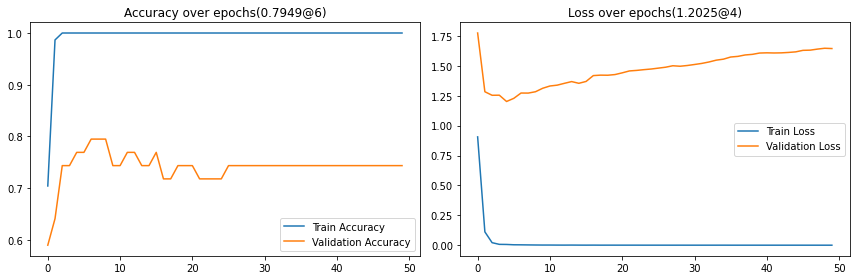

위와 같고 aug(90도 rotate, contrast)
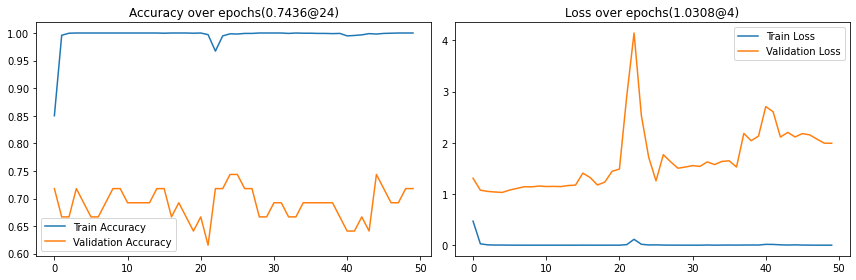

model-2, no aug, dense 32, batchnormal, resnet retrain from 177(conv5 block3) + rgb_stardization
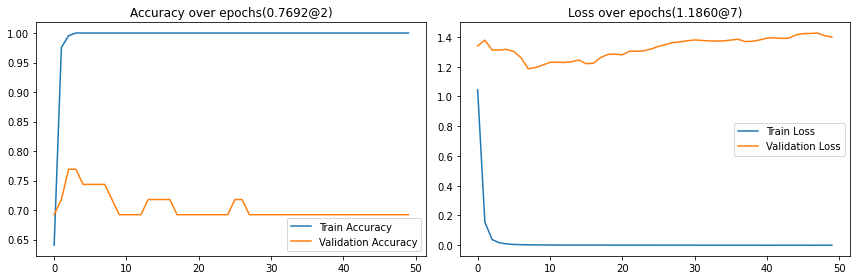

## MobileNet V2

no aug, dense 32, no retrain
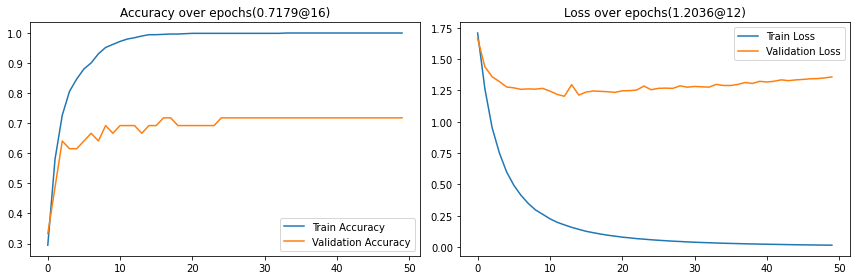

no aug, dense 32, retrain from 143 (마지막 block?) epoch 50
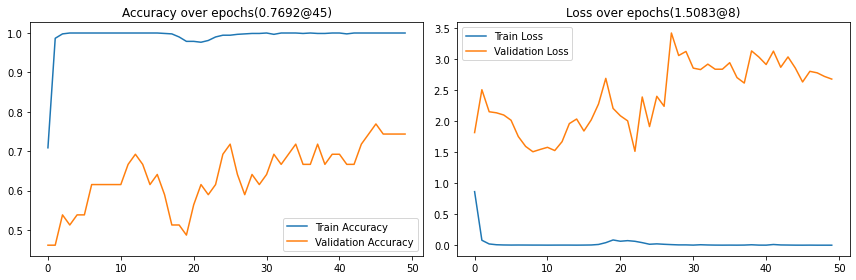

위와 같음(no aug, dense 32, retrain from 143 (마지막 block?) epoch 50) + rgb_standardization
- 특징 : metric의 수렴이 굉장히 빠르다. 반면, val metric의 모양도 안정적이다.
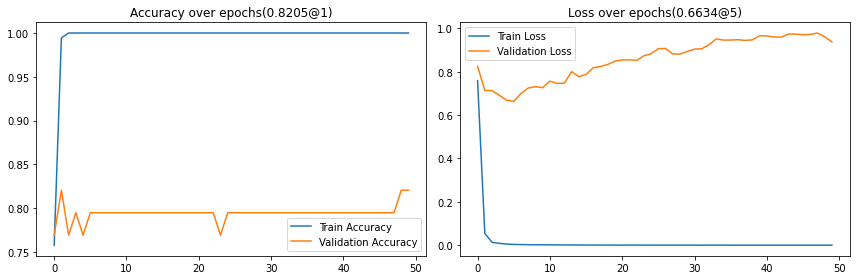

## DenseNet

dense 32, densnet no retrain + rgb_stardization
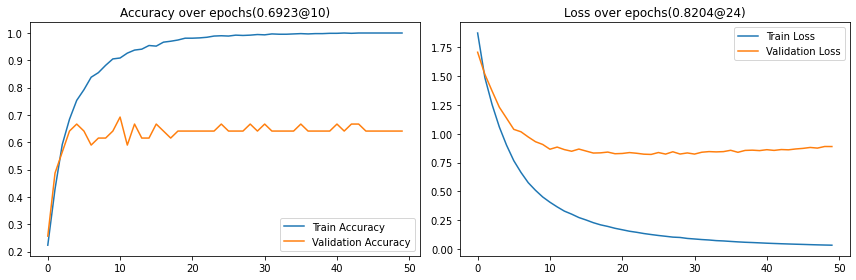

dense 32, densnet no train(100) + rgb_stardization
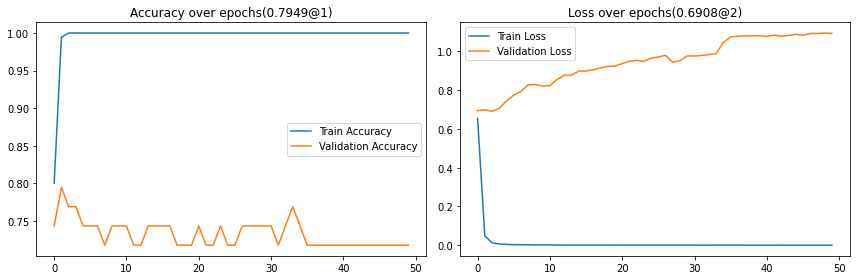

dense 32, densnet no train(313: conv5 ~) + rgb_stardization
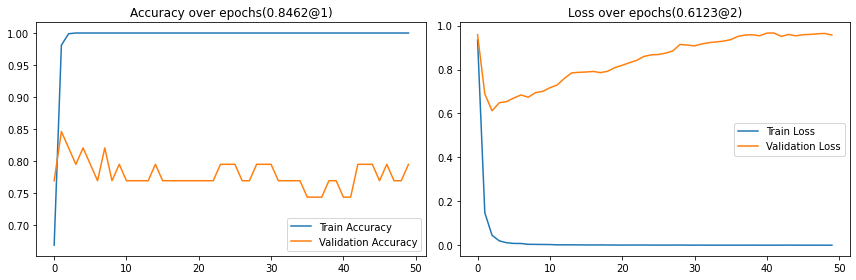

### Data : label reviewed + 추가 수집
#### MobileNet

epoch = 100, retrain = true, train_from = 144
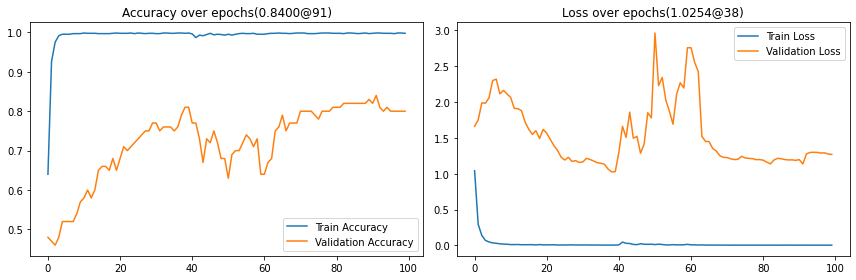